In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('inferences.csv', sep=',', index_col=0)
noises = df['NOISE'].drop_duplicates().tolist()
datasets = df['DATASET'].drop_duplicates().tolist()
models = df['MODEL'].drop_duplicates().tolist()
df

,NOISE,DATASET,MODEL,ERR_AVG,ERR_STD,ERR_MAX,ERR_MIN
0,0.0,SIMULATION_00_03,FF_200,0.003097,0.000324,0.007659,0.000428
1,0.0,SIMULATION_00_03,FF_400,0.000288,0.000059,0.000366,0.000223
2,0.0,SIMULATION_00_03,FF_800,0.000247,0.000108,0.000368,0.000107
3,0.0,SIMULATION_00_03,FF_1600,0.000077,0.000031,0.000107,0.000034
4,0.0,SIMULATION_00_03,PIDNN_200,0.000072,0.000071,0.000173,0.000021
...,...,...,...,...,...,...,...
100,0.1,SIMULATION_00_40,FF_800,0.001914,0.000726,0.002725,0.000964
101,0.1,SIMULATION_00_40,FF_1600,0.001189,0.000559,0.001731,0.000419
102,0.1,SIMULATION_00_40,PIDNN_200,0.000815,0.000194,0.001079,0.000617
103,0.1,SIMULATION_00_40,PIDNN_400,0.000595,0.000281,0.000916,0.000232


[3.09700556e-03 2.88103149e-04 2.47121434e-04 7.71715046e-05
 7.23900588e-05 1.79248248e-05 1.76895707e-05]
[3.24164608e-04 5.92324308e-05 1.07517220e-04 3.11647768e-05
 7.13792753e-05 8.67534512e-07 1.84906049e-06]


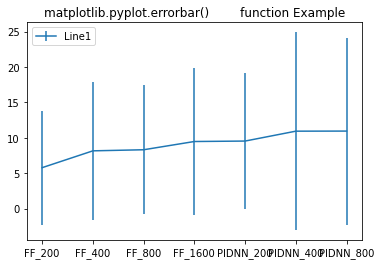

In [3]:
for noise in noises[:1]:
    for dataset in datasets[:1]:
        rdf = df.loc[(df['NOISE'] == noise) & (df['DATASET'] == dataset)]
        fig = plt.figure()
        x = rdf['MODEL'].tolist()
        y = np.array(rdf['ERR_AVG'].tolist())
        yerr = np.array(rdf['LOG_STD'].tolist())

        plt.errorbar(x, -np.log(y), yerr = yerr,
                    label ='Line1')
        
        plt.legend(loc ='upper left')
        
        plt.title('matplotlib.pyplot.errorbar()\
        function Example')
        plt.show()